In [1]:
import sys, os
sys.path.insert(0, '../..')
# os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
import numpy as np
import pandas as pd
import torch
from models.weighted_node2vec import WeightedNode2Vec
from dataset import triplet_dataset, pokec_data
from utils.config import DEVICE
import gc
from tqdm import trange
from utils.link_prediction import GCNLinkPrediction
import residual2vec as rv
import warnings
import faiss
import matplotlib.pyplot as plt
from utils.score import statistical_parity
from utils.snakemake_utils import FileResources
import seaborn as sns
from utils import snakemake_utils
warnings.filterwarnings("ignore")
gc.enable()

/data/sg/ashutiwa/miniconda3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using GPU: cuda:0


In [3]:
from dataset import polblog_data
y = polblog_data.PolBlogDataFrame().get_grouped_col()

In [4]:
sp_score, roc_score, gini_score, embs = {}, {}, {}, {}
DATA_ROOT = '//data/sg/ashutiwa/final_results/polblog/'
! ls /data/sg/ashutiwa/final_results/small_pokec/
DIRS = ['data_one/', 'data_two/', 'data_three/', 'data_four/']
DATASET = 'polblog'
M = ["GCN_baseline", "GCN_r2v", "GCN_baseline_crosswalk", "GCN_r2v_crosswalk", 
     "GAT_baseline","GAT_r2v", "GAT_baseline_crosswalk", "GAT_r2v_crosswalk"]
k=5
N_EDGES = 

data_four  data_one  data_three  data_two


# distributions of positive and negative edgeswith dot product

In [5]:
def get_roc_score(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)
def get_roc_score_(df):
    from sklearn.metrics import roc_auc_score
    y_pred = np.concatenate((df.positive_dot.values, df.negative_dot.values))
    from sklearn.preprocessing import MinMaxScaler
    y_pred = MinMaxScaler().fit_transform([y_pred])[0]
    y_true = np.concatenate((np.ones_like(df.positive_dot.values), np.zeros_like(df.negative_dot.values)))
    return roc_auc_score(y_true, y_pred)

In [6]:
def plot_dot_(df, title):
#     df = pd.DataFrame({
#         "positive_dot": np.array([np.dot(a[i], p[i]) for i in trange(a.shape[0])]),
#         "negative_dot": np.array([np.dot(a[i], n[i]) for i in trange(a.shape[0])])
#     })
    
#     fig, ax = plt.subplots(1,1)
    df.positive_dot.plot(kind='density', title=title)
    df.negative_dot.plot(kind='density', title=title)
#     ax.set_xlim(-1000, 1000)
    ax.legend(['positive_neighbors', 'negative_neighbors'])
#     fig.show()

# GCN ( baseline)

In [7]:
model = "GCN_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gcn_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

((1224, 128), (1224, 128), (1224, 128))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 329577.46it/s]


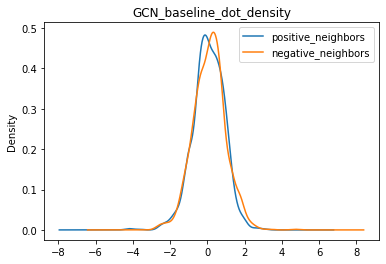

In [8]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [9]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

WARNING clustering 1224 points to 35 centroids: please provide at least 1365 training points


ValueError: number sections must be larger than 0.

# GCN ( baseline + crosswalk)

In [ ]:
model = "GCN_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN ( r2v)

In [ ]:
model = "GCN_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET  + '_gcn_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GCN ( r2v + crosswalk)

In [ ]:
model = "GCN_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gcn_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT ( baseline)

In [ ]:
model = "GAT_baseline"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT ( baseline + crosswalk)

In [ ]:
model = "GAT_baseline_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT ( r2v)

In [ ]:
model = "GAT_r2v"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_gat_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# GAT ( r2v + crosswalk)

In [ ]:
model = "GAT_r2v_crosswalk"
embs[model] = np.load(DATA_ROOT + DIRS[0] + DATASET + '_crosswalk_gat_r2v_node2vec_embs.npy')
emb = embs[model]
A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
A.shape, P.shape, N.shape

In [ ]:
# plot density
dot = pd.DataFrame({
        "positive_dot": np.array([np.dot(A[i], P[i]) for i in trange(A.shape[0])]),
        "negative_dot": np.array([np.dot(A[i], N[i]) for i in trange(A.shape[0])])
    })
fig, ax = plt.subplots(1,1)

plot_dot_(dot, title=model + '_dot_density')
# ax.set_xlim(-750, 750)
ax.legend(['positive_neighbors', 'negative_neighbors'])
fig.show()

In [ ]:
# # create edge_list
batch_size = 2000

edges = snakemake_utils.return_new_graph(A, k, )
gini_score[model] = statistical_parity(edges, y, metric='gini')
sp_score[model] = statistical_parity(edges, y, )

roc_score[model] = get_roc_score(dot)
edges.shape, sp_score[model], roc_score[model], gini_score[model]

# plot statistical parity scores

# gini sp scores

In [ ]:

for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")

# sp scores

In [ ]:

for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

# roc auc scores

In [ ]:

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [ ]:

N = 20

sp_scores, gini_scores = np.zeros((N, len(M))), np.zeros((N, len(M)))
for k in range(N):
    for idx, m in enumerate(M):
        if k == 0: continue
        batch_size =  2000
        A = embs[m][:, :128]
        edges = snakemake_utils.return_new_graph(A, k, )
        
    
        gini_scores[k, idx] = statistical_parity(edges, y, metric='gini')
        sp_scores[k, idx] = statistical_parity(edges, y, )


In [ ]:
for i in range(len(M)):
    plt.plot(gini_scores[:, i], label=M[i])
plt.legend(loc="upper right")
plt.title("gini scores vs # nn")

In [ ]:
for i in range(len(M)):
    plt.plot(sp_scores[:, i], label=M[i])
plt.legend(loc="upper right")

plt.title("sp scores vs # nn")

# combine all different runs

In [ ]:
MODEL_NAME_2_FILE = {
    "GCN_baseline": "_gcn_node2vec_embs.npy",
    "GCN_baseline_crosswalk": "_crosswalk_gcn_node2vec_embs.npy",
    "GCN_r2v": "_gcn_r2v_node2vec_embs.npy",
    "GCN_r2v_crosswalk": '_crosswalk_gcn_r2v_node2vec_embs.npy',
    "GAT_baseline": '_gat_node2vec_embs.npy',
    "GAT_baseline_crosswalk": "_crosswalk_gat_node2vec_embs.npy",
    "GAT_r2v": "_gat_r2v_node2vec_embs.npy",
    "GAT_r2v_crosswalk": "_crosswalk_gat_r2v_node2vec_embs.npy"
}
def roc_scores(model_name):
    scores = np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        emb = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
        dot = pd.DataFrame({
            "positive_dot": np.array([np.dot(A[i], P[i]) for i in range(A.shape[0])]),
            "negative_dot": np.array([np.dot(A[i], N[i]) for i in range(A.shape[0])])
        })
        scores[idx] = get_roc_score(dot)
    return np.mean(scores)


def statisticalp_scores(model_name, K=5):
    scores, scores_gini = np.zeros(len(DIRS)), np.zeros(len(DIRS))
    for idx, d in enumerate(DIRS):
        emb = np.load(DATA_ROOT + d + DATASET + MODEL_NAME_2_FILE[model_name])
        A, P, N = emb[:, :128], emb[:, 128: 128 * 2], emb[:, 128 * 2:]
        edges = snakemake_utils.return_new_graph(A, K)
        scores_gini[idx] = statistical_parity(edges, y, metric='gini')
        
        scores[idx] = statistical_parity(edges, y, )
    return np.mean(scores), np.mean(scores_gini)

In [ ]:

roc_score = {m: roc_scores(m) for m in MODEL_NAME_2_FILE}

for i, j in roc_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(roc_score.keys()), y=list(roc_score.values()))
ax.set_ylim(min(roc_score.values()), max(roc_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("roc scores")

In [ ]:

temp = {m: statisticalp_scores(m) for m in MODEL_NAME_2_FILE}

sp_score = {m: v[0] for m,v in temp.items()}
for i, j in sp_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(sp_score.keys()), y=list(sp_score.values()))
ax.set_ylim(min(sp_score.values()), max(sp_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("statistical parity scores")

In [ ]:
gini_score = {m: v[1] for m,v in temp.items()}
for i, j in gini_score.items(): print(i, j)
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.barplot(x=list(gini_score.keys()), y=list(gini_score.values()))
ax.set_ylim(min(gini_score.values()), max(gini_score.values()))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 45)
ax.set_title("gini statistical parity scores")